In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat, u_darrays
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [2]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [4]:
ar = xr.open_dataset('/home/ck/DIR/cornkle/data/CRUTEM.4.6.0.0.anomalies.nc')

In [5]:
ar

<xarray.Dataset>
Dimensions:              (latitude: 36, longitude: 72, time: 2016)
Coordinates:
  * latitude             (latitude) float32 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude            (longitude) float32 -177.5 -172.5 ... 172.5 177.5
  * time                 (time) datetime64[ns] 1850-01-16T12:00:00 ... 2017-12-16T12:00:00
Data variables:
    temperature_anomaly  (time, latitude, longitude) float32 ...
    field_status         (time) |S1 ...
Attributes:
    title:        CRUTEM4 temperature anomalies
    institution:  Climatic Research Unit, University of East Anglia/Met Offic...
    history:      
    source:       
    comment:      
    reference:    Jones, P. D., D. H. Lister, T. J. Osborn, C. Harpham, M. Sa...
    version:      CRUTEM.4.6.0.0
    Conventions:  CF-1.0

In [206]:
data = ar['temperature_anomaly'].sel(longitude=slice(-22,55),latitude=slice(-40,40))

In [207]:
def calc_trend(mean_years, method='mk', sig=False):
    # stack lat and lon into a single dimension called allpoints
    datastacked = mean_years.stack(allpoints=['latitude', 'longitude'])

    # apply the function over allpoints to calculate the trend at each point
    print('Entering trend calc')

    alpha = 0.05
    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='mk':
        dtrend = datastacked.groupby('allpoints').apply(u_darrays.linear_trend_mk, alpha=alpha, eps=0.0001,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')
        if sig:
            (dtrend['slope'].values)[dtrend['ind'].values==0] = 0
            
    return dtrend

In [208]:
timesel = data.sel(time=slice('1983-01-16', '2017-12-16'))

In [219]:
month = timesel[timesel['time.month'] == 11]

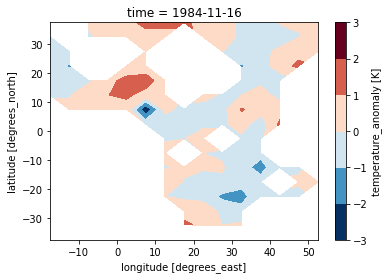

In [220]:
month[1,:,:].plot.contourf()

In [221]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show()   

In [222]:
month.time

<xarray.DataArray 'time' (time: 35)>
array(['1983-11-16T00:00:00.000000000', '1984-11-16T00:00:00.000000000',
       '1985-11-16T00:00:00.000000000', '1986-11-16T00:00:00.000000000',
       '1987-11-16T00:00:00.000000000', '1988-11-16T00:00:00.000000000',
       '1989-11-16T00:00:00.000000000', '1990-11-16T00:00:00.000000000',
       '1991-11-16T00:00:00.000000000', '1992-11-16T00:00:00.000000000',
       '1993-11-16T00:00:00.000000000', '1994-11-16T00:00:00.000000000',
       '1995-11-16T00:00:00.000000000', '1996-11-16T00:00:00.000000000',
       '1997-11-16T00:00:00.000000000', '1998-11-16T00:00:00.000000000',
       '1999-11-16T00:00:00.000000000', '2000-11-16T00:00:00.000000000',
       '2001-11-16T00:00:00.000000000', '2002-11-16T00:00:00.000000000',
       '2003-11-16T00:00:00.000000000', '2004-11-16T00:00:00.000000000',
       '2005-11-16T00:00:00.000000000', '2006-11-16T00:00:00.000000000',
       '2007-11-16T00:00:00.000000000', '2008-11-16T00:00:00.000000000',
       '2009-1

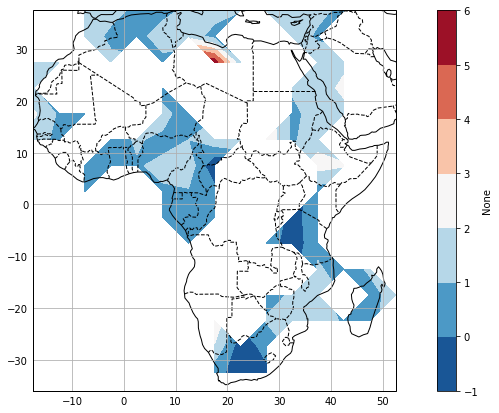

In [223]:
draw_map(month[-3,:,:], month.longitude, month.latitude, cmap='RdBu_r')

In [224]:
month.values[np.isnan(month.values)]=0

In [225]:
trend = calc_trend(month)

Entering trend calc


/home/ck/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [226]:
vtrend = trend['slope']
mask = trend['ind']

/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


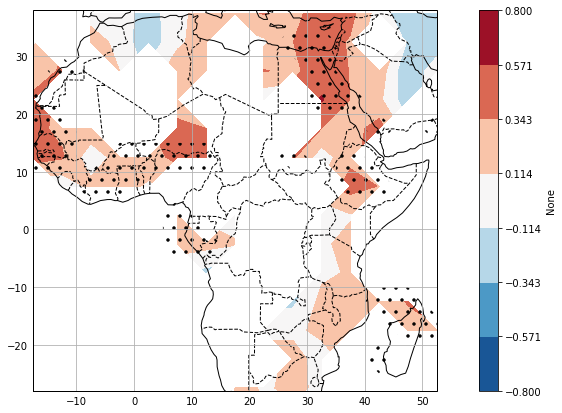

In [227]:
draw_map(vtrend*10, month.longitude, month.latitude, cmap='RdBu_r', levels=np.linspace(-0.8,0.8,8), mask_sig=mask)